In [18]:
import pandas as pd
import numpy as np
import cv2
import os
from termcolor import colored
import matplotlib.pyplot as plt

images = pd.DataFrame()

data_path = r"data"
imaging_path = r"imaging_subset"

filenames = os.listdir(os.path.join(data_path, imaging_path))
depths = pd.read_csv(os.path.join(data_path, "depths.csv"))

for i in filenames:
    img = cv2.imread(os.path.join(data_path, imaging_path, i), 0)
    try:
        depth = depths[depths["Filenames"].str.lower() == i.lower()][
            "Depth from lung surface (in micrometers) where image was acquired"
        ].values[0]
        # some files are named with SK658 and some with Sk658
    except IndexError:
        print(f"couldn't find depth for file {i}")
        continue
    images = pd.concat(
        [images, pd.DataFrame([{"filename": i, "image": img, "depth": depth}])],
        ignore_index=True,
    )
display(images.head())

,filename,image,depth
0,MASK_SK658 Slobe ch010048.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",540
1,MASK_Sk658 Llobe ch010061.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",585
2,MASK_SK658 Slobe ch010103.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9600
3,MASK_SK658 Slobe ch010063.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7400
4,MASK_SK658 Slobe ch010113.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1,...",7300


In [25]:
# add area column

areas = pd.read_csv(os.path.join(data_path, "manual_contour_area.csv"))
if not ("area_pixels" in images.columns):
    images = images.merge(areas, on=["filename", "depth"], how="left")

display(images.head())

,filename,image,depth,area_pixels
0,MASK_SK658 Slobe ch010048.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",540,339495
1,MASK_Sk658 Llobe ch010061.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",585,175368
2,MASK_SK658 Slobe ch010103.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9600,192249
3,MASK_SK658 Slobe ch010063.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7400,85161
4,MASK_SK658 Slobe ch010113.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1,...",7300,49410


In [ ]:
white_percents_w_area = []

for x_glm_all in range(len(images)):
    _, binary = cv2.threshold(images.iloc[x_glm_all]["image"], 127, 255, cv2.THRESH_BINARY)
    area = images.iloc[x_glm_all]["area_pixels"]
    white = np.sum(binary == 255)
    black = np.sum(binary == 0)

    white_percent = 100 * (white / (black + white - area))
    white_percents_w_area.append(white_percent)

white_percents = []

for x_glm_all in range(len(images)):
    _, binary = cv2.threshold(images.iloc[x_glm_all]["image"], 127, 255, cv2.THRESH_BINARY)
    white = np.sum(binary == 255)
    black = np.sum(binary == 0)

    white_percent = 100 * (white / (black + white))
    white_percents.append(white_percent)

In [27]:
df = pd.DataFrame(
    {
        "filename": images["filename"],
        "depth": images["depth"],
        "white_percent_w_area": white_percents_w_area,
        "white_percent": white_percents,
    }
)
if input("save to file? (y/n) ") == "y":
    df.to_csv(os.path.join(data_path, "merged_all.csv"), index=False)


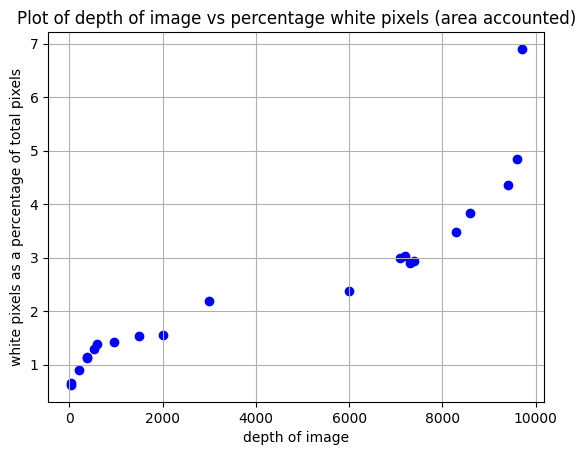

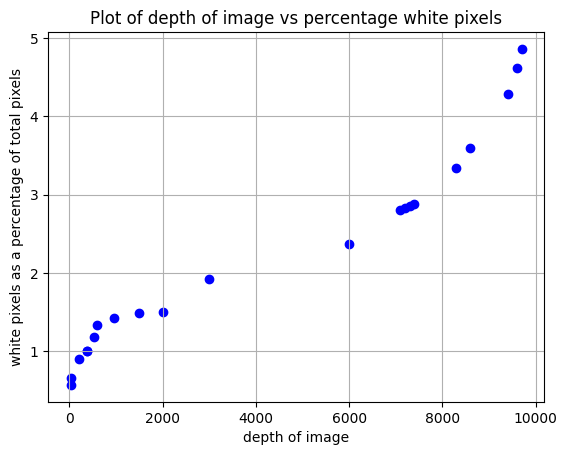

In [30]:
# display graph
plt.scatter(images["depth"], white_percents_w_area, marker="o", linestyle="-", color="blue")
plt.title("Plot of depth of image vs percentage white pixels (area accounted)")
plt.xlabel("depth of image")
plt.ylabel("white pixels as a percentage of total pixels")
plt.grid(True)
plt.show()

plt.scatter(images["depth"], white_percents, marker="o", linestyle="-", color="blue")
plt.title("Plot of depth of image vs percentage white pixels")
plt.xlabel("depth of image")
plt.ylabel("white pixels as a percentage of total pixels")
plt.grid(True)
plt.show()

                  Generalized Linear Model Regression Results                   
Dep. Variable:     white_percent_w_area   No. Observations:                   21
Model:                              GLM   Df Residuals:                       19
Model Family:                  Gaussian   Df Model:                            1
Link Function:                      Log   Scale:                         0.29506
Method:                            IRLS   Log-Likelihood:                -15.982
Date:                  Wed, 15 Oct 2025   Deviance:                       5.6062
Time:                          21:57:45   Pearson chi2:                     5.61
No. Iterations:                       8   Pseudo R-squ. (CS):             0.9993
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0822      0.152

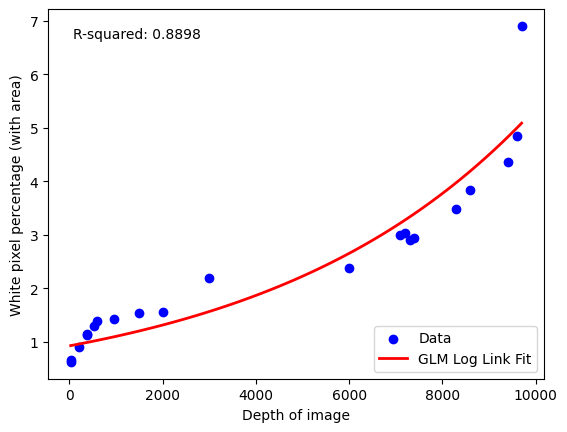

In [94]:
# generalized linear model
import statsmodels.api as sm

# prepare the data
x_glm = df["depth"]
y_glm = df["white_percent_w_area"]

# add a constant for the intercept
x_const = sm.add_constant(x_glm)

# fit glm
glm_model_area = sm.GLM(
    y_glm, x_const, family=sm.families.Gaussian(link=sm.families.links.Log())
).fit()

# print the summary
print(glm_model_area.summary())

# calculate R-squared
fitted_values = glm_model_area.fittedvalues
ss_total = ((y_glm - y_glm.mean()) ** 2).sum()
ss_residual = ((y_glm - fitted_values) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
print(f"R-squared: {r_squared}")

# plot the regression curve
x_pred = np.linspace(x_glm.min(), x_glm.max(), 100)
x_pred_const = sm.add_constant(x_pred)
y_pred = glm_model_area.predict(x_pred_const)
plt.scatter(x_glm, y_glm, color="blue", label="Data")
plt.plot(x_pred, y_pred, color="red", linewidth=2, label="GLM Log Link Fit")
plt.text(
    0.05,
    0.95,
    f"R-squared: {r_squared:.4f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
)
plt.xlabel("Depth of image")
plt.ylabel("White pixel percentage (with area)")
plt.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:          white_percent   No. Observations:                   78
Model:                            GLM   Df Residuals:                       76
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -109.93
Date:                Wed, 15 Oct 2025   Deviance:                       9.5621
Time:                        21:57:56   Pearson chi2:                     10.5
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5891
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0617      0.170     -0.363      0.7

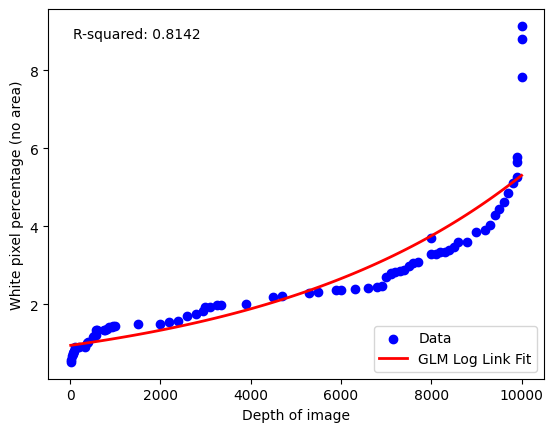

In [95]:
# generalized linear model
import statsmodels.api as sm
images_all = pd.DataFrame()

data_path = r"data"
imaging_path = r"imaging"
filenames = os.listdir(os.path.join(data_path, imaging_path))
images_all = pd.read_csv(os.path.join(data_path, "pct_white_pixels.csv"))

# prepare the data
x_glm_all = images_all["depth"]
y_glm_all = images_all["white_percent"]

# add a constant for the intercept
x_const = sm.add_constant(x_glm_all)

# fit a GLM
glm_model_no_area = sm.GLM(
    y_glm_all, x_const, family=sm.families.Poisson(link=sm.families.links.Log())
).fit()

# print the summary
print(glm_model_no_area.summary())

# calculate R-squared
fitted_values_all = glm_model_no_area.fittedvalues
ss_total_all = ((y_glm_all - y_glm_all.mean()) ** 2).sum()
ss_residual_all = ((y_glm_all - fitted_values_all) ** 2).sum()
r_squared_all = 1 - (ss_residual_all / ss_total_all)
print(f"R-squared: {r_squared_all}")

# plot the regression curve
x_pred_all = np.linspace(x_glm_all.min(), x_glm_all.max(), 100)
x_pred_const = sm.add_constant(x_pred_all)
y_pred = glm_model_no_area.predict(x_pred_const)
plt.scatter(x_glm_all, y_glm_all, color="blue", label="Data")
plt.plot(x_pred_all, y_pred, color="red", linewidth=2, label="GLM Log Link Fit")
plt.legend()
plt.text(0.05, 0.95, f"R-squared: {r_squared_all:.4f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Depth of image")
plt.ylabel("White pixel percentage (no area)")
plt.show()

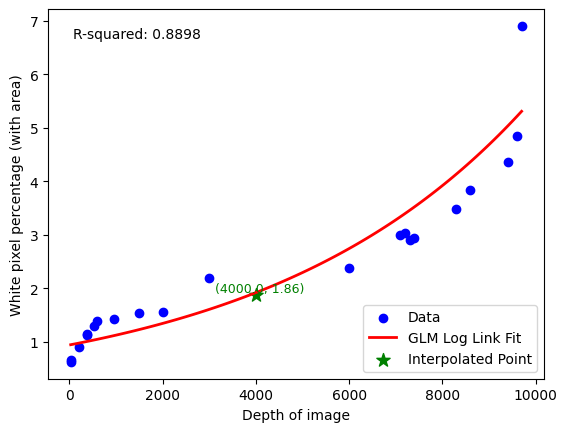

In [96]:
# interpolate points using glm (with area accounted for)

inp_depth = input("Enter depth to estimate white pixel percentage at: ")
inp_depth = float(inp_depth)

# single-point prediction
x_point = np.array([[1, inp_depth]])  # include constant if the model was fit with one
y_point = glm_model_area.predict(x_point)[0]

# curve
x_curve = np.linspace(x_glm_all.min(), x_glm_all.max(), 100)
X_curve = sm.add_constant(x_curve)
y_curve = glm_model_area.predict(X_curve)

plt.scatter(x_glm, y_glm, color="blue", label="Data")
plt.plot(x_pred, y_pred, color="red", linewidth=2, label="GLM Log Link Fit")
plt.text(
    0.05,
    0.95,
    f"R-squared: {r_squared:.4f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
)
# add interpolated point as star
plt.scatter(inp_depth, y_point, color="green", s=100, label="Interpolated Point", marker="*")
plt.text(
    inp_depth, y_point,
    f"  ({inp_depth}, {y_point:.2f})",
    verticalalignment="bottom",
    horizontalalignment="center",
    fontsize=9,
    color="green"
)
plt.legend()
plt.xlabel("Depth of image")
plt.ylabel("White pixel percentage (with area)")
plt.show()